In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

from random import seed, random, randint, sample

from keras.models import Model, save_model, load_model
from keras.layers import Input, Dense, BatchNormalization, TimeDistributed, ELU
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras.utils import to_categorical

import pickle as pkl

%matplotlib inline

Using TensorFlow backend.


In [2]:
def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res/(SS_tot + K.epsilon())

In [3]:
# Input layer
input_layer = Input(shape=(4000, 125))

# Encoder
encoder_layer_1 = TimeDistributed(Dense(64))(input_layer)
encoder_layer_1 = TimeDistributed(BatchNormalization())(encoder_layer_1)
encoder_layer_1 = TimeDistributed(ELU())(encoder_layer_1)

encoder_layer_2 = TimeDistributed(Dense(16))(encoder_layer_1)
encoder_layer_2 = TimeDistributed(BatchNormalization())(encoder_layer_2)
encoder_layer_2 = TimeDistributed(ELU())(encoder_layer_2)

encoder_layer_3 = TimeDistributed(Dense(16))(encoder_layer_2)
encoder_layer_3 = TimeDistributed(BatchNormalization())(encoder_layer_3)
encoder_layer_3 = TimeDistributed(ELU())(encoder_layer_3)

# Latent Space
latent_space = TimeDistributed(Dense(8))(encoder_layer_3)
latent_space = TimeDistributed(BatchNormalization())(latent_space)
latent_space = TimeDistributed(ELU(), name="latent_space_out")(latent_space)

# Decoder
decoder_layer_1 = TimeDistributed(Dense(16))(latent_space)
decoder_layer_1 = TimeDistributed(BatchNormalization())(decoder_layer_1)
decoder_layer_1 = TimeDistributed(ELU())(decoder_layer_1)

decoder_layer_2 = TimeDistributed(Dense(32))(decoder_layer_1)
decoder_layer_2 = TimeDistributed(BatchNormalization())(decoder_layer_2)
decoder_layer_2 = TimeDistributed(ELU())(decoder_layer_2)

decoder_layer_3 = TimeDistributed(Dense(64))(decoder_layer_2)
decoder_layer_3 = TimeDistributed(BatchNormalization())(decoder_layer_3)
decoder_layer_3 = TimeDistributed(ELU())(decoder_layer_3)

# Output layer
output_layer = TimeDistributed(Dense(125))(decoder_layer_3)

# Autoencoder Model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Display the model summary
autoencoder.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4000, 125)         0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4000, 64)          8064      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 4000, 64)          256       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 4000, 64)          0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 4000, 16)          1040      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 4000, 16)          64        
_________________________________________________________________
time_distributed_6 (TimeDist (None, 4000, 16)          0   

In [4]:
autoencoder.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error', metrics=[r_squared])

In [5]:
training_data = np.load('training_features.npz')
validation_data = np.load('validation_features.npz')
testing_data = np.load('testing_features.npz')

In [6]:
x_train, y_train = training_data['a'], training_data['b']
x_val, y_val = validation_data['a'], validation_data['b']
x_test, y_test = testing_data['a'], testing_data['b']

In [7]:
x_test = np.concatenate((x_val, x_test), axis=0)
y_test = np.concatenate((y_val, y_test), axis=0)

In [8]:
print(f"Training-> {x_train.shape},  {y_train.shape}")
#print(f"Validation-> {x_val.shape},  {y_val.shape}")
print(f"Testing-> {x_test.shape},  {y_test.shape}")

Training-> (930, 4000, 125),  (930, 1)
Testing-> (348, 4000, 125),  (348, 1)


In [9]:
# label shape formatting 
labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
num_classes = len(labels)
y_train = to_categorical(y_train, num_classes)
#y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

In [10]:
print(f"Training hot label-> {y_train.shape}")
#print(f"Validation hot label-> {y_val.shape}")
print(f"Testing hot label-> {y_test.shape}")

Training hot label-> (930, 8)
Testing hot label-> (348, 8)


In [11]:
history1 = autoencoder.fit(x_train, x_train, epochs=50, batch_size=128, shuffle=True, validation_data=(x_test, x_test))

Train on 930 samples, validate on 348 samples
Epoch 1/50
930/930 [==============================] - 15s 16ms/step - loss: 8.6518 - r_squared: -0.0101 - val_loss: 8.7950 - val_r_squared: 0.0156
Epoch 2/50
930/930 [==============================] - 12s 13ms/step - loss: 7.9575 - r_squared: 0.0676 - val_loss: 8.4259 - val_r_squared: 0.0571
Epoch 3/50
930/930 [==============================] - 10s 11ms/step - loss: 7.3415 - r_squared: 0.1429 - val_loss: 7.9620 - val_r_squared: 0.1092
Epoch 4/50
930/930 [==============================] - 10s 11ms/step - loss: 6.7264 - r_squared: 0.2154 - val_loss: 7.4775 - val_r_squared: 0.1635
Epoch 5/50
930/930 [==============================] - 11s 12ms/step - loss: 6.1493 - r_squared: 0.2783 - val_loss: 6.9563 - val_r_squared: 0.2219
Epoch 6/50
930/930 [==============================] - 11s 12ms/step - loss: 5.5722 - r_squared: 0.3509 - val_loss: 6.4554 - val_r_squared: 0.2781
Epoch 7/50
930/930 [==============================] - 11s 12ms/step - loss: 5

In [12]:
with open('./autoencoder_history.pkl', 'wb') as file:
    pkl.dump(history1.history, file)

In [45]:
with open('./autoencoder_history.pkl', 'rb') as f:
    data = pkl.load(f)

ERROR! Session/line number was not unique in database. History logging moved to new session 552


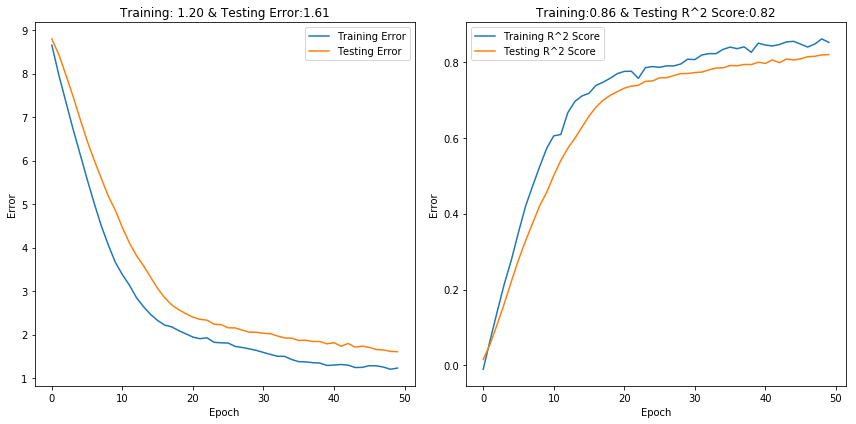

In [55]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
min_loss = min(data['loss'])
min_val_loss = min(data['val_loss'])
plt.plot(data['loss'], label='Training Error')
plt.plot(data['val_loss'], label='Testing Error')
plt.title(f'Training: {min_loss:.2f} & Testing Error:{min_val_loss:.2f}')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()

max_r = max(data['r_squared'])
max_val_r = max(data['val_r_squared'])
plt.subplot(1, 2, 2)
plt.plot(data['r_squared'], label='Training R^2 Score')
plt.plot(data['val_r_squared'], label='Testing R^2 Score')
plt.title(f'Training:{max_r:.2f} & Testing R^2 Score:{max_val_r:.2f}')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
save_model(autoencoder, './autoencoder_model.h5')
print("Autoencoder Model Saved...")

Autoencoder Model Saved...


In [14]:
#autoencoder = load_model('./autoencoder_model.h5')

In [15]:
from keras.models import Model
from keras.layers import Input, Conv1D, ELU, BatchNormalization, MaxPooling1D, LSTM, Dense, Softmax
from keras.metrics import categorical_accuracy, Precision, Recall

In [16]:
def unweighted_accuracy(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    class_samples = K.sum(y_true, axis=0)
    
    unweighted_accuracy = K.sum(true_positives / K.maximum(class_samples, 1)) / K.sum(K.cast(class_samples > 0, 'float32'))
    return unweighted_accuracy



def weighted_accuracy(y_true, y_pred):
    class_weights = K.sum(y_true, axis=0)  # Assuming one-hot encoded labels
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    total_samples = K.sum(class_weights)
    
    weighted_accuracy = K.sum((true_positives / K.maximum(class_weights, 1)) * (class_weights / total_samples))
    return weighted_accuracy

In [56]:
# Assuming 'autoencoder' is your trained autoencoder model
# Assuming 'latent_space_layer_name' is the name of the latent space layer in your autoencoder

# Extracting the encoder part from the autoencoder model
encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("latent_space_out").output, name='encoder_model')

# Freeze the layers of the encoder during classification
for layer in encoder_model.layers:
    layer.trainable = False

# Classifier architecture on top of the encoder
classifier_input = encoder_model.output

# Convolutional layers
classifier_output = Conv1D(128, kernel_size=3, padding='same', name='conv1')(classifier_input)
classifier_output = ELU(name='elu1')(classifier_output)
classifier_output = TimeDistributed(BatchNormalization(name='batch_norm1'))(classifier_output)
classifier_output = MaxPooling1D(pool_size=2, name='maxpool1')(classifier_output)

classifier_output = Conv1D(256, kernel_size=3, padding='same', name='conv2')(classifier_output)
classifier_output = ELU(name='elu2')(classifier_output)
classifier_output = TimeDistributed(BatchNormalization(name='batch_norm2'))(classifier_output)
classifier_output = MaxPooling1D(pool_size=2, name='maxpool2')(classifier_output)

classifier_output = Conv1D(512, kernel_size=3, padding='same', name='conv3')(classifier_output)
classifier_output = ELU(name='elu3')(classifier_output)
classifier_output = TimeDistributed(BatchNormalization(name='batch_norm3'))(classifier_output)
classifier_output = MaxPooling1D(pool_size=2, name='maxpool3')(classifier_output)

# LSTM layer
classifier_output = LSTM(128, name='lstm')(classifier_output)

# Dense layers
classifier_output = Dense(128, name='dense1')(classifier_output)
classifier_output = ELU(name='elu_dense1')(classifier_output)
classifier_output = BatchNormalization(name='batch_norm_dense1')(classifier_output)

classifier_output = Dense(8, activation='softmax', name='output')(classifier_output)

# Create the classifier model
classifier_model = Model(inputs=encoder_model.input, outputs=classifier_output, name='classifier_model')

# Compile the classifier model
classifier_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy', weighted_accuracy, unweighted_accuracy])

# Display the classifier model summary
classifier_model.summary()


Model: "classifier_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4000, 125)         0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4000, 64)          8064      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 4000, 64)          256       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 4000, 64)          0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 4000, 16)          1040      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 4000, 16)          64        
_________________________________________________________________
time_distributed_6 (TimeDist (None, 4000, 16)     

In [57]:
# Train the final model
history2 = classifier_model.fit(
    x_train, y_train,
    epochs=50,             
    batch_size=64,        
    shuffle=True,
    validation_data=(x_test, y_test))


Train on 930 samples, validate on 348 samples
Epoch 1/50
930/930 [==============================] - 49s 53ms/step - loss: 2.1773 - accuracy: 0.2473 - weighted_accuracy: 0.0655 - unweighted_accuracy: 0.0719 - val_loss: 1.9991 - val_accuracy: 0.2414 - val_weighted_accuracy: 0.0000e+00 - val_unweighted_accuracy: 0.0000e+00
Epoch 2/50
930/930 [==============================] - 21s 23ms/step - loss: 1.6358 - accuracy: 0.4086 - weighted_accuracy: 0.1501 - unweighted_accuracy: 0.1603 - val_loss: 1.9718 - val_accuracy: 0.2471 - val_weighted_accuracy: 0.0000e+00 - val_unweighted_accuracy: 0.0000e+00
Epoch 3/50
930/930 [==============================] - 23s 25ms/step - loss: 1.4227 - accuracy: 0.5075 - weighted_accuracy: 0.2338 - unweighted_accuracy: 0.2484 - val_loss: 1.9747 - val_accuracy: 0.2414 - val_weighted_accuracy: 0.0052 - val_unweighted_accuracy: 0.0024
Epoch 4/50
930/930 [==============================] - 21s 22ms/step - loss: 1.3406 - accuracy: 0.5430 - weighted_accuracy: 0.2850 - un

930/930 [==============================] - 21s 22ms/step - loss: 0.7300 - accuracy: 0.7634 - weighted_accuracy: 0.6599 - unweighted_accuracy: 0.6722 - val_loss: 2.4558 - val_accuracy: 0.2960 - val_weighted_accuracy: 0.1202 - val_unweighted_accuracy: 0.1026
Epoch 32/50
930/930 [==============================] - 21s 23ms/step - loss: 0.6883 - accuracy: 0.7656 - weighted_accuracy: 0.6401 - unweighted_accuracy: 0.6655 - val_loss: 2.5093 - val_accuracy: 0.2069 - val_weighted_accuracy: 0.1235 - val_unweighted_accuracy: 0.1163
Epoch 33/50
930/930 [==============================] - 21s 23ms/step - loss: 0.6725 - accuracy: 0.7796 - weighted_accuracy: 0.6865 - unweighted_accuracy: 0.6958 - val_loss: 2.9014 - val_accuracy: 0.1897 - val_weighted_accuracy: 0.1358 - val_unweighted_accuracy: 0.1343
Epoch 34/50
930/930 [==============================] - 21s 23ms/step - loss: 0.6498 - accuracy: 0.7828 - weighted_accuracy: 0.6746 - unweighted_accuracy: 0.6856 - val_loss: 2.6191 - val_accuracy: 0.3132 - 

In [35]:
with open('./classifier_history.pkl', 'wb') as file:
    pkl.dump(history2.history, file)

In [36]:
save_model(classifier_model, './classifier_model.h5')
print("classifier Model Saved...")

classifier Model Saved...


In [37]:
y_pred_train = classifier_model.predict(x_train)
#y_pred_val = classifier_model.predict(x_val)
y_pred_test = classifier_model.predict(x_test)

In [58]:
y_pred_train_labels = np.argmax(y_pred_train, axis=1)
#y_pred_val_labels = np.argmax(y_pred_val, axis=1)
y_pred_test_labels = np.argmax(y_pred_test, axis=1)

In [59]:
cm1 = confusion_matrix(np.argmax(y_train, axis=1), y_pred_train_labels)
#cm2 = confusion_matrix(np.argmax(y_val, axis=1), y_pred_val_labels)
cm3= confusion_matrix(np.argmax(y_test, axis=1), y_pred_test_labels)


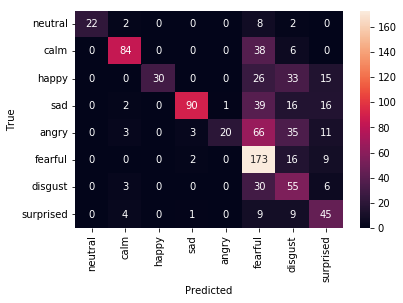

In [60]:
sns.heatmap(cm1, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

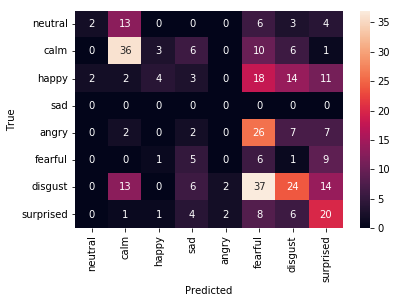

In [61]:
sns.heatmap(cm3, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()